# Week 7 - Support Vector Machines

### Aims

The main concepts covered in this notebook are: 

>* understanding separable vs non-separable data
>* implementing SVMs
>* use of different kernels and parameter tuning in SVMs


1. [Setup](#setup)

2. [SVC](#SVC)

3. [Model assessment](#assess)

4. [Default Data](#default)


This week, we will be exploring the basics of support vector machine models. We will be focusing on support vector machines for classification, which is provided by sklearn in the `SVC` model. For more details, please see https://scikit-learn.org/stable/modules/svm.html

The main class that we are using is [sklearn.svm.SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)

As usual, during workshops, you will complete the worksheets together in teams of 2-3, using **pair programming**. When completing worksheets:

>- You will have tasks tagged by (CORE) and (EXTRA). 
>- Your primary aim is to complete the (CORE) components during the WS session, afterwards you can try to complete the (EXTRA) tasks for your self-learning process. 

Instructions for submitting your workshops can be found at the end of worksheet. As a reminder, you must submit a pdf of your notebook on Learn by 16:00 PM on the Friday of the week the workshop was given.

# Setup <a id='setup'></a>

## Packages

Let's load the some of the packages needed for this workshop. 

In [1]:
# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn modules
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC         # SVM
from sklearn.preprocessing import StandardScaler # scaling features
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold

## Helper Functions

This helper function plots the data and visualized the decision boundary and margin. 

In [2]:
from sklearn.inspection import DecisionBoundaryDisplay
import sklearn.preprocessing

# Visualize the decision boundary and margin
# For D=2 inputs and binary classification
def plot_margin(model, X, y, figsize=(8,7)):
    
    fig, ax = plt.subplots(1,1,figsize=figsize)

    # Scatter plot of the inputs colored by class 
    ax.scatter(X[:,0], X[:,1], c=y, s=30)
    
    # Show decsision boundary
    DecisionBoundaryDisplay.from_estimator(
        model,
        X,
        plot_method="contour",
        colors="k",
        levels=[-1, 0, 1],
        linestyles=["--", "-", "--"],
        ax=ax,
    )

    # Highlight support vectors
    # If pipeline with StandardScalar, inverse transform the support vectors
    if (isinstance(model, sklearn.pipeline.Pipeline)):
        if (isinstance(model[0], sklearn.preprocessing.StandardScaler)):
            support_vectors = model[0].inverse_transform(model[-1].support_vectors_)
        else:
            support_vectors = model[-1].support_vectors_
    else:
        support_vectors = model.support_vectors_
    ax.scatter(
        support_vectors[:, 0],
        support_vectors[:, 1],
        s=100,
        linewidth=1,
        facecolors="none",
        edgecolors="k",
    )
    plt.show()

# Support Vector Classifier <a id='SVC'></a>

The class [`SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) implements support vector classifiers and support vector machines. When creating an `SVC` object, various options are available, including:

- `C`: the inverse regularizaton parameter. NOTE: this defaults to `C=1` but should always be tuned. 
- `kernel`: options include the  **linear** kernel (`linear`), **polynomial** kernel (`poly`), **radial basis function** kernel (`rbf`), **sigmoid** kernel (`sigmoid`), or a user-defined kernel.
- `degree`: degree if using the **polynomial** kernel
- `gamma`: kernel coefficient for **rbf**, **polynomial**, or **sigmoid** kernels.
- `coef0`: additional coefficient term for the  **polynomial** or **sigmoid** kernels.

After calling `.fit()`, the `SVC` object will have a number of attributes including:

- `support_vectors_`: containing the support vectors.

To predict the class labels from the fitted SVC model, we can call `.predict()`. And although SVMs only provide class labels and not the corresponding class probabilities, `SVC` provides a method to estimate the class probablities by calling `.predict_proba()` (or `.predict_log_proba()` on the log scale) using Platt scaling. This uses cross-validation and makes the implementation slower, thus to turn on this option of estimating the class probabilities, you must first set `probability=True` when creating the `SVC` object. Also note that these probability estimates are unreliable on small datasets.

More details on **kernels** are available here: 
https://scikit-learn.org/stable/modules/svm.html#svm-kernels

### **Difference between SVC and LinearSVC**

Note the `sklearn` implements two linear support vector classification models `LinearSVC()` and `SVC(kernel='linear')`, which yield slightly different decision boundaries, due to the following differences:

>- `LinearSVC` (based on LIBLINEAR) is **faster** than `SVC` (based on LIBSVM)
>- `LinearSVC` minimizes the squared hinge loss while SVC minimizes the regular hinge loss.
>- `LinearSVC` uses the One-vs-Rest scheme for multiclass classification while `SVC` uses the One-vs-One scheme for multiclass classification.
>- `LinearSVC` does not provide some of the attributes of `SVC`, such as the support vectors.

For further details, see the documentations of the two classes

- `SVC` with `kernel=linear`: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
- `LinearSVC`: https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html

In the following, we will focus on the `SVC` class.

## Linearly Separable Data 

We will begin by examining various toy data sets to explore the basics of these models. For the first example, we will read in data from `ex1.csv`.


In [3]:
ex1 = pd.read_csv("ex1.csv")
ex1.head()

,x1,x2,y
0,-0.56,-1.07,A
1,-0.23,-0.22,A
2,1.56,-1.03,A
3,0.07,-0.73,A
4,0.13,-0.63,A


Plotting the data below, we can see the that data is composed of two classes in two dimensions, and it is clear that these two classes are linearly separable.

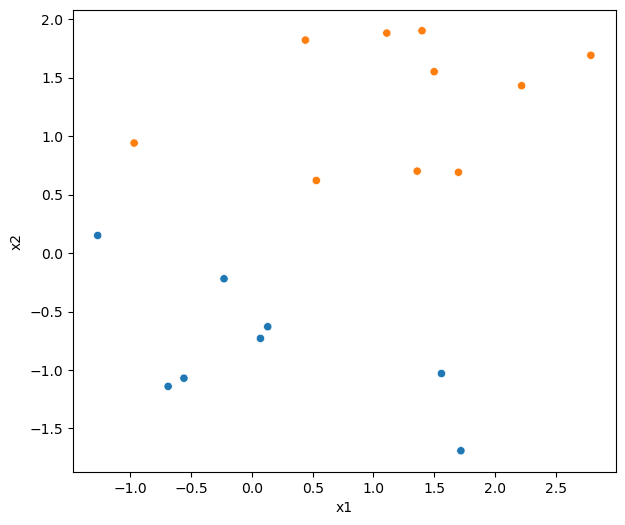

In [4]:
plt.figure(figsize=(7,6))
sns.scatterplot(x='x1', y='x2', hue='y', data=ex1, legend=False)
plt.show()

Now, let separate the features and outcome and encode the outcome to a binary vector. 

In [5]:
# Extracting the features and output and encoding y
X_ex1 = np.array(ex1.drop('y', axis=1))
y_ex1 = LabelEncoder().fit_transform(ex1.y)

print(X_ex1.shape)
print(y_ex1.shape)

(18, 2)
(18,)


### 🚩 Exercise 1 (CORE)

a. Create and fit an SVC model using a **linear kernel** and `C=100`.

b. Visualize the decision boundary, margin, and support vectors using the function `plot_margin` defined above. How many support vectors are there for each class? Are they on right side of the margin? hyperplane?

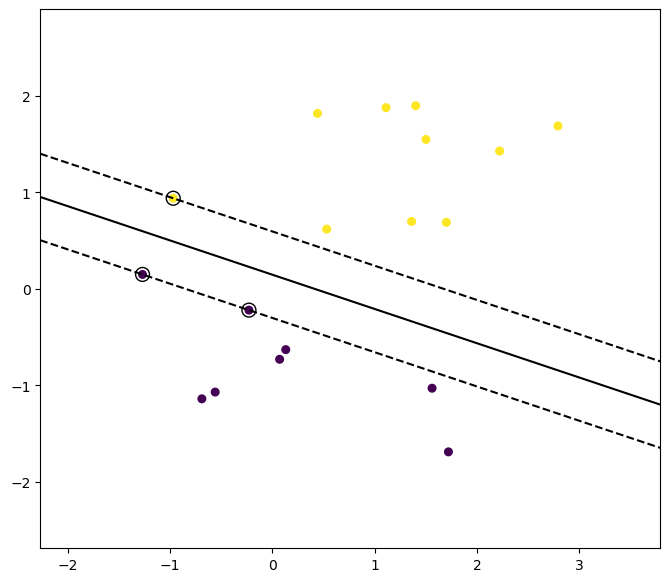

In [6]:
# Fit the SVC
svm = SVC(kernel='linear', C=100).fit(X_ex1, y_ex1)

# Visualize the decision boundary, margin and support vectors
plot_margin(svm, X_ex1,y_ex1)

In total there are three support vectors:
- 1 support vector in the yellow class on the decision boundary, and 
- 2 support vectors in the purple class both on the decision boundary.

### 🚩 Exercise 2  (CORE)

Now, let's see how the results change with a small value of `C`.

a. Create and fit an SVC model using a **linear kernel** and `C=1`.

b. Visualize the decision boundary, margin, and support vectors. Now, how many support vectors are there for each class? Are they on right side of the margin? hyperplane? How has the margin changed?

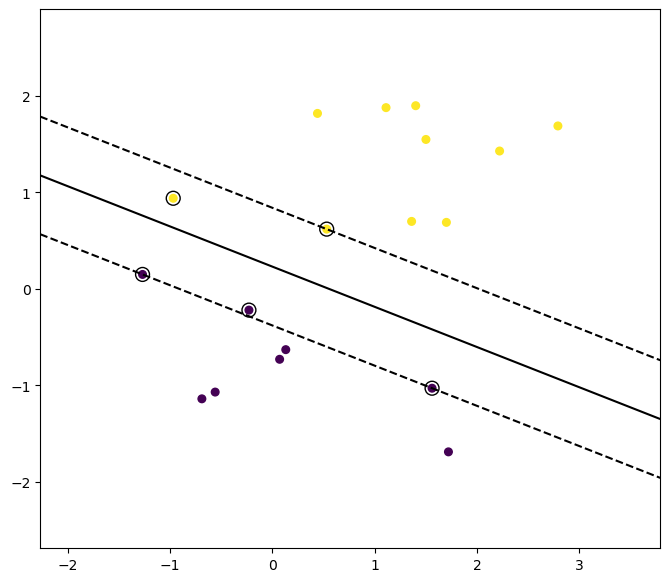

In [7]:
# Fit the SVC with a smaller value of C
svm2 = SVC(kernel='linear', C=1).fit(X_ex1, y_ex1)

# Visualize the decision boundary, margin and support vectors
plot_margin(svm2, X_ex1,y_ex1)

Now, the margin is larger. A smaller value of $C$ places more emphasis on minimizing the $\ell_2$ norm of the weights at the cost of larger slack variables. This results in an increase in the number of support vectors (from 3 to 5 in total), and for each class:
- there are two support vectors for the yellow class, one on the decision boundary and one on the wrong side of the margin but correct side of the hyperplane.
- there are three support vectors for the purple class, two on the decision boundary, and one on the wrong side of the margin but correct side of the hyperplane. 

## Non-Separable Data

Next, we complicate our previous example by adding two additional points from class A to our data, which result in data that are no longer linearly separable. 

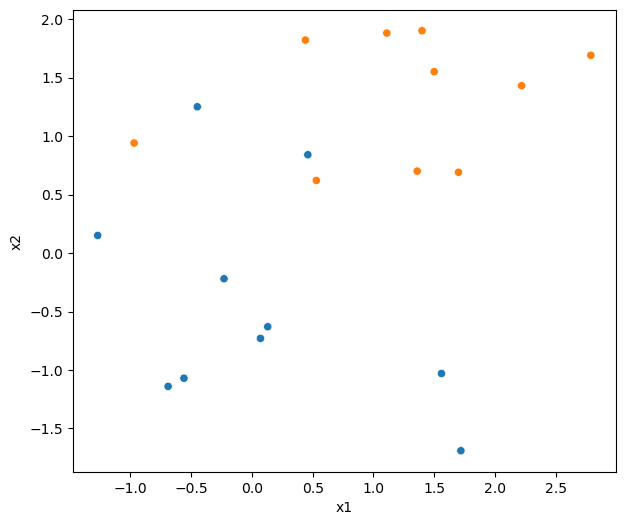

In [8]:
# Read in the data
ex2 = pd.read_csv("ex2.csv")

# Visualize the data
plt.figure(figsize=(7,6))
sns.scatterplot(x='x1', y='x2', hue='y', data=ex2, legend=False)
plt.show()

# Extracting the features and output and encoding y
X_ex2 = np.array(ex2.drop('y', axis=1))
y_ex2 = LabelEncoder().fit_transform(ex2.y)

### 🚩 Exercise 3  (CORE)

Fit the SVC model using the **linear kernel** and **same choices of `C=100` and `C=1`**. How have the results changed? Comment on changes related to the margin and the number of support vectors for each class and their location relative to the margin and hyperplane. 

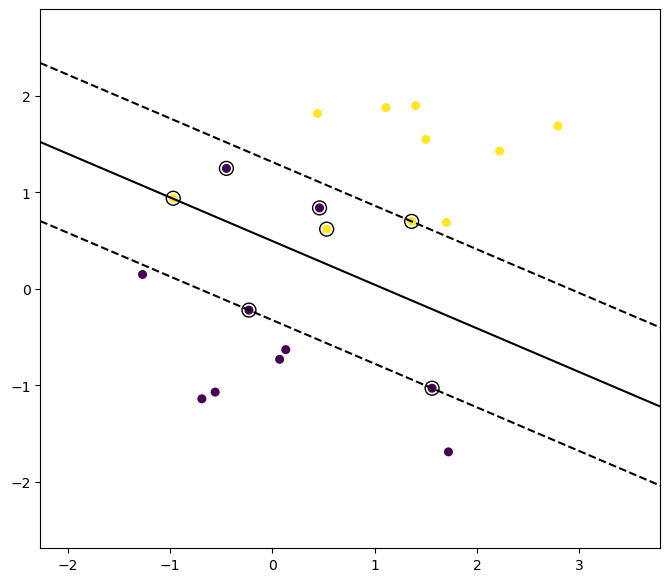

In [9]:
# Fit the SVC on the new data with a larger value of C
svm = SVC(kernel='linear', C=100).fit(X_ex2, y_ex2)

# Visualize the decision boundary, margin and support vectors
plot_margin(svm, X_ex2,y_ex2)

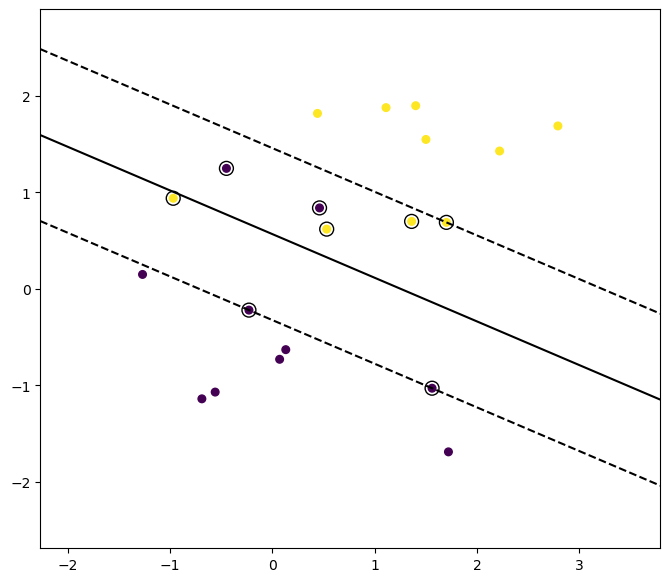

In [10]:
# Fit the SVC on the new data with a smaller value of C
svm2 = SVC(kernel='linear', C=1).fit(X_ex2, y_ex2)

# Visualize the decision boundary, margin and support vectors
plot_margin(svm2, X_ex2,y_ex2)

Now, the data are no longer linearly separable, i.e. there is no line that can perfectly separate these two classes. Comparing the results with the previous case, we observe:

- the margins are now larger for the same choices of C
- for `C=100`, the number of support vectors has increased from 3 to 7 (three yellow and four purple). Before all points were on the correct side of the margin, but now in non-separable case, there are two purple points on the wrong side of the hyperplane, and two yellow points on the correct side of the hyperplane but on the wrong side of the margin.
- for `C=1`, the number of support vectors has increased to 8. The behavior of the support vectors has changed for the yellow class, with one additional support vector and one point now on the wrong side of the margin. 

## Nonlinear Separation

Next, we will look at a new data set that is not linearly separable, but can be perfectly separated by a nonlinear decision boundary. We will start by loading and visualizing the data.

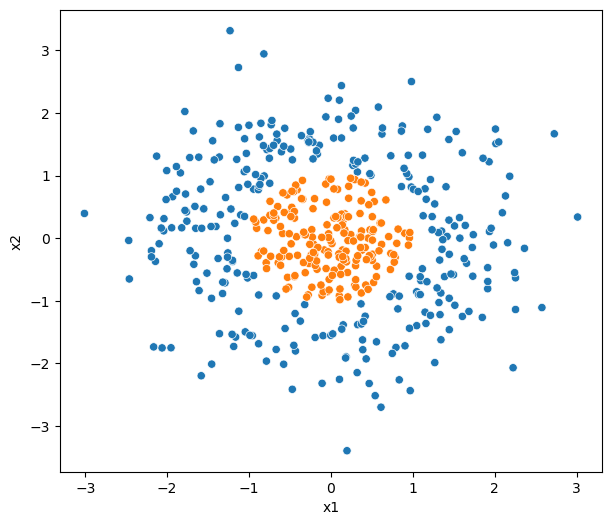

In [11]:
# Load the third data set
ex3 = pd.read_csv("ex3.csv")

# Visualize the data
plt.figure(figsize=(7,6))
sns.scatterplot(x='x1', y='x2', hue='y', data=ex3, legend=False)
plt.show()

# Extracting the features and output and encoding y
X_ex3 = np.array(ex3.drop('y', axis=1))
y_ex3 = LabelEncoder().fit_transform(ex3.y)

Let's start by trying to fit a linear SVC. As expected, the results are terrible and the number of support vectors is very large.

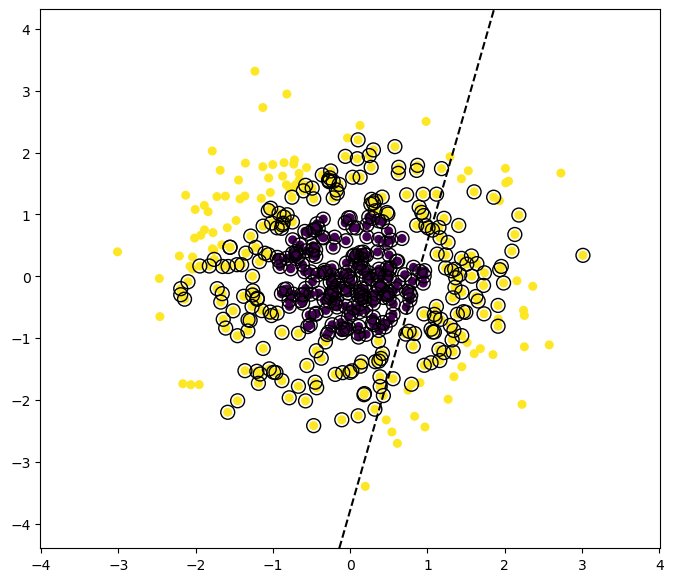

In [12]:
# Fit the SVC with a linear kernel on the new data 
svm_lin = SVC(kernel='linear', C=100).fit(X_ex3, y_ex3)

# Visualize the decision boundary, margin and support vectors
plot_margin(svm_lin, X_ex3,y_ex3)

### 🚩 Exercise 4  (CORE)

- Fit an SVM with a **polynomial kernel with degree 2** and `C=100`.
- Visualize the margin and decision boundary and comment on the number of support vectors compared to the linear model.
- Compute and visualize the confusion matrix using `ConfusionMatrixDisplay.from_estimator`. Is the fitted SVM able to perfectly separate the classes?

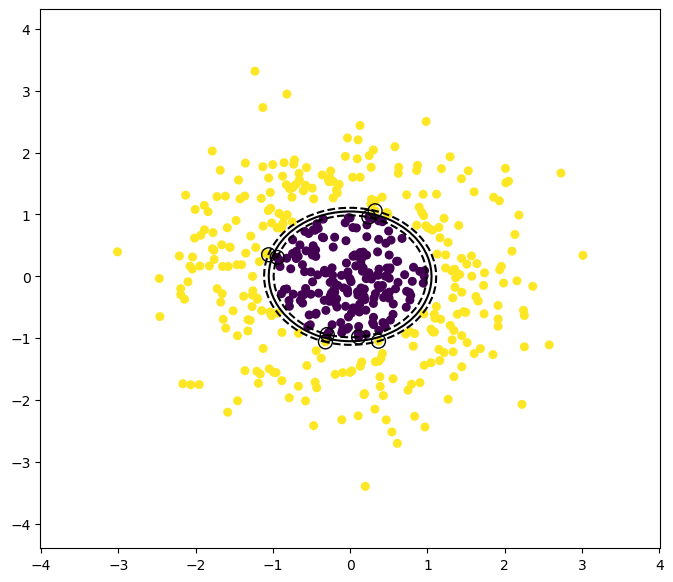

Number of support vectors for the nonlinear model: [4 4]
Number of support vectors for the linear model: [185 205]


In [13]:
# Fit the SVM
svm = SVC(kernel = 'poly', degree = 2, C = 100).fit(X_ex3, y_ex3)

# Visualize the decision boundary, margin and support vectors
plot_margin(svm, X_ex3,y_ex3)

print('Number of support vectors for the nonlinear model:', svm.n_support_)
print('Number of support vectors for the linear model:', svm_lin.n_support_)

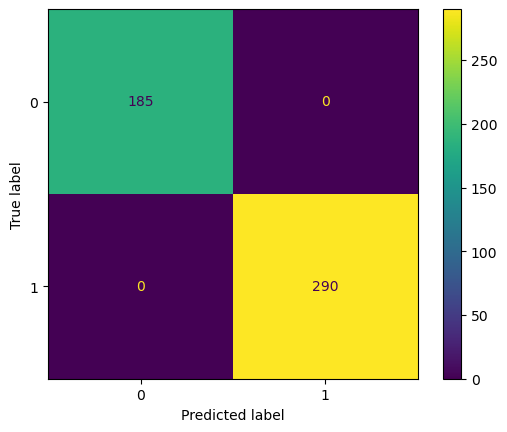

In [14]:
ConfusionMatrixDisplay.from_estimator(svm, X_ex3, y_ex3)
plt.show()

- The polynomial kernel with degree two produces a circular decision boundary, which fits the data well and is able to perfectly separate the two classes.

- There are now only eight support vectors, which is much reduced compared to the linear model.

## Kernels for SVMs and Parameter-Tuning

Next, we will consider an more complicated data, and explore using grid search to tune the model parameters and the effect of different kernels.


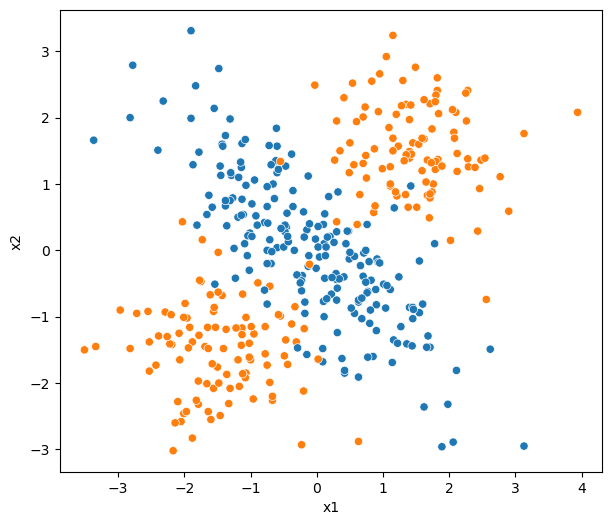

In [15]:
# Load the fourth data set
ex4 = pd.read_csv("ex4.csv")

# Visualize the data
plt.figure(figsize=(7,6))
sns.scatterplot(x='x1', y='x2', hue='y', data=ex4, legend=False)
plt.show()

# Extracting the features and output and encoding y
X_ex4 = np.array(ex4.drop('y', axis=1))
y_ex4 = LabelEncoder().fit_transform(ex4.y)

Let's start with the polynomial kernel that we saw in the previous exercise and use cross-validation to tune both the degree of polynomial and the penalty parameter.

In [16]:
# SVM with polynomial kernel
svm = SVC(kernel='poly', coef0=1)

# Grid search over C and the degree of the polynomial
degrees = [1,2,3,4]
C = np.linspace(0.1, 10, 100)
cv = GridSearchCV(
    svm,
    param_grid = {'C': C,
        'degree': degrees},
    cv = KFold(5, shuffle = True, random_state = 0)
)

# Fit and tune the model
cv.fit(X_ex4, y_ex4)

# Get the best model parameters and the accuracy of the model
print("Params: ", cv.best_params_)
print("Avg Accuracy: ", cv.best_score_)

Params:  {'C': 3.1, 'degree': 2}
Avg Accuracy:  0.9425000000000001


### 🚩 Exercise 5  (CORE)

- Run the following code to plot the CV accuracy. Based on this plot, would you use the best parameter values printed above or choose different values? Why?
- For your selected parameters, fit the svm and plot the decision boundary and margin.

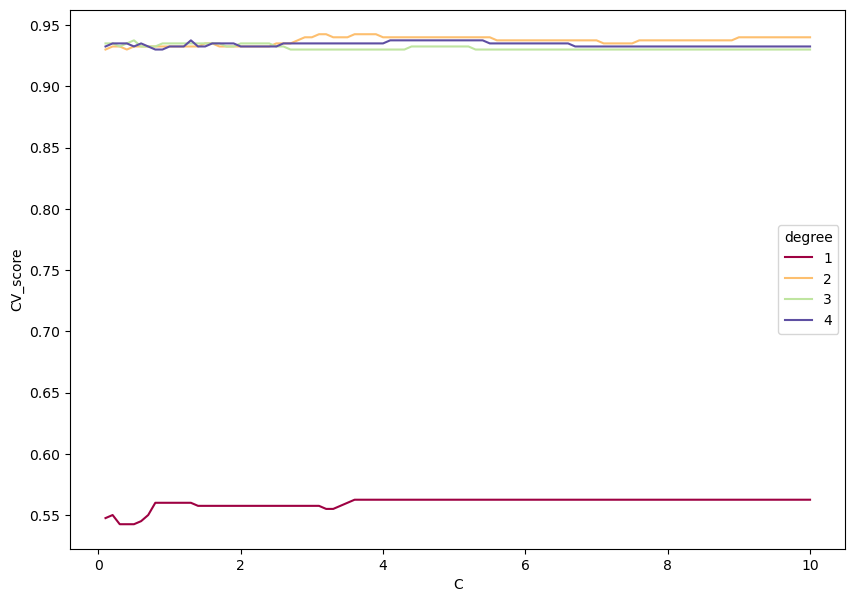

In [17]:
# Store cv scores in a data frame 
cv_accuracy = pd.DataFrame(cv.cv_results_
                           ).filter(['param_C', 'param_degree','mean_test_score']
                                    ).rename(columns={'param_C':'C', 'param_degree':'degree','mean_test_score':'CV_score'})

# Plot the CV scores
plt.figure(figsize=(10,7))
sns.lineplot(x='C', y='CV_score', data = cv_accuracy, hue ='degree', palette="Spectral") 
plt.show()

We observe a major improvement with any degree above one, which is expected, as a linear decision boundary is clearly not sufficient for this data. The curves for degrees of 2,3,4 are quite similar, thus we would prefer the simpler model with a degree of 2 (which is also the degree found by grid search). In addition, the CV scores are quite flat as a function of the penalty parameter, thus, we would prefer the simpler model with a stronger penalty (smaller C). Based on these observations, the best parameter values found by the grid search are reasonable. 

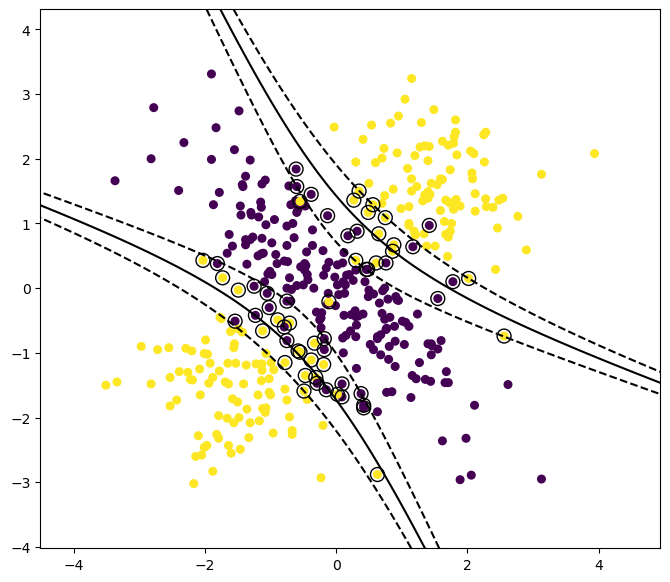

In [18]:
# Visualize the decision boundary
plot_margin(cv.best_estimator_, X_ex4,y_ex4)

### 🚩 Exercise 6  (EXTRA)

- Repeat the grid search above with a polynomial kernel but set the coefficent term `coef0=0` (this is the default value). Redraw the plot of the CV accuracy. How have the results changed? Can you explain why?

Params:  {'C': 2.3000000000000003, 'degree': 2}
Avg Accuracy:  0.9349999999999999


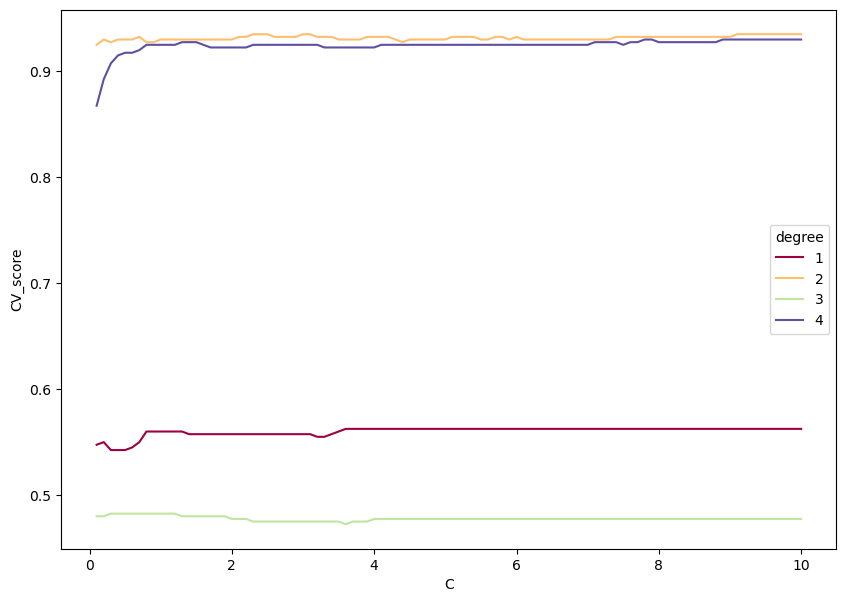

In [19]:
# SVM with polynomial kernel
svm0 = SVC(kernel='poly', coef0=0)

# Grid search over C and the degree of the polynomial
degrees = [1,2,3,4]
C = np.linspace(0.1, 10, 100)
cv0 = GridSearchCV(
    svm0,
    param_grid = {'C': C,
        'degree': degrees},
    cv = KFold(5, shuffle = True, random_state = 0)
)

# Fit and tune the model
cv0.fit(X_ex4, y_ex4)

# Get the best model parameters and the accuracy of the model
print("Params: ", cv0.best_params_)
print("Avg Accuracy: ", cv0.best_score_)

# Store cv scores in a data frame 
cv_accuracy = pd.DataFrame(cv0.cv_results_
                           ).filter(['param_C', 'param_degree','mean_test_score']
                                    ).rename(columns={'param_C':'C', 'param_degree':'degree','mean_test_score':'CV_score'})

# Plot the CV scores
plt.figure(figsize=(10,7))
sns.lineplot(x='C', y='CV_score', data = cv_accuracy, hue ='degree', palette="Spectral") 
plt.show()

The main difference is that degree three now performs quite terribly. Remember that the kernel trick implicity maps the features to a new (higher-dimensional) feature space. When the coefficient is set to zero, this new feature space has a lower dimension, compared with a coeffcient of 1; thus the model is less flexible. To see why, let's focus on the one-dimensional setting:
$$ k(x_n,x_{n'}) = (x_n x_{n'})^2 = x_n^2 x_{n'}^2 = \phi(x_n)^T \phi(x_{n'}),$$
where $\phi(x) = x^2$, i.e. we only have one new feature. Instead, with a coefficient of 1, we have
$$ k(x_n,x_{n'}) = (x_n x_{n'}+1)^2 = x_n^2 x_{n'}^2 + 2x_n x_{n'}  +1 = \phi(x_n)^T \phi(x_{n'}),$$
where $\phi(x) = (1,\sqrt{2}x, x^2)$, i.e. we have three new features.

### 🚩 Exercise 7  (CORE)

Consider instead the RBF kernel. 

- Use grid search to tune both the penalty parameter $C$ and the inverse bandwidth parameter $\gamma$.

- Plot the decision boundary. How do the results compare to the SVM with a polynomial kernel?

Params:  {'C': 1.1, 'gamma': 1}
Avg Accuracy:  0.9475


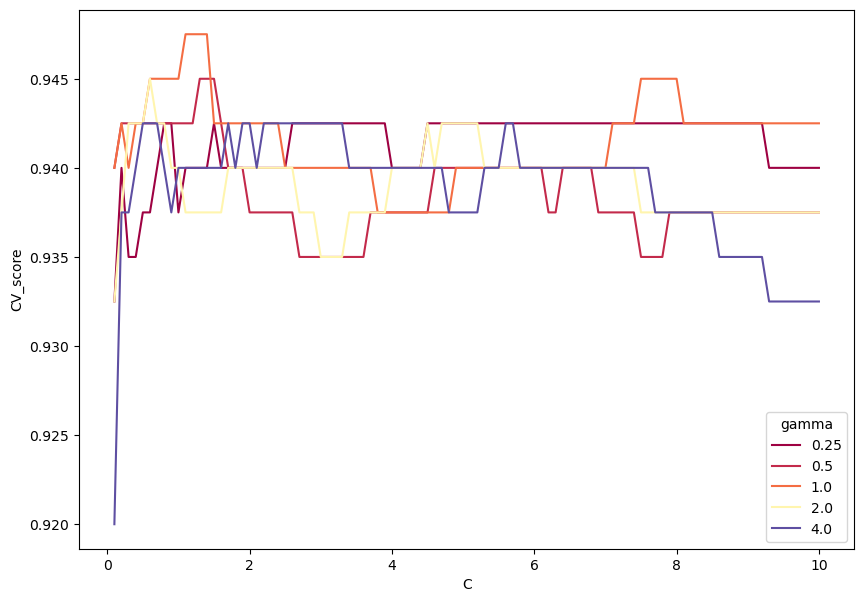

In [20]:
# SVM with rbfkernel
svm2 = SVC(kernel='rbf')

# Grid search over C and the inverse bandwidth
gamma = [1/4,1/2,1,2,4]
C = np.linspace(0.1, 10, 100)
cv2 = GridSearchCV(
    svm2,
    param_grid = {'C': C,
        'gamma': gamma},
    cv = KFold(5, shuffle = True, random_state = 0)
)

# Fit and tune the model
cv2.fit(X_ex4, y_ex4)

# Get the best model parameters and the accuracy of the model
print("Params: ", cv2.best_params_)
print("Avg Accuracy: ", cv2.best_score_)

# Store cv scores in a data frame 
cv_accuracy = pd.DataFrame(cv2.cv_results_
                           ).filter(['param_C', 'param_gamma','mean_test_score']
                                    ).rename(columns={'param_C':'C', 'param_gamma':'gamma','mean_test_score':'CV_score'})

# Plot the CV scores
plt.figure(figsize=(10,7))
sns.lineplot(x='C', y='CV_score', data = cv_accuracy, hue ='gamma', palette="Spectral") 
plt.show()

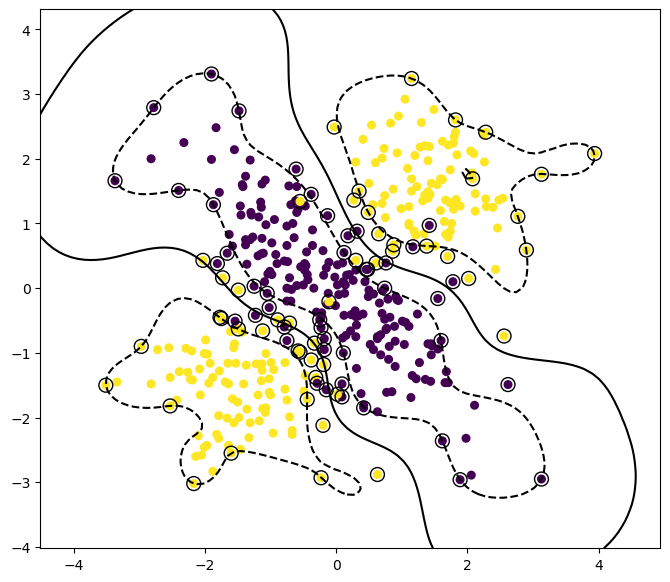

In [21]:
# Visualize the decision boundary
plot_margin(cv2.best_estimator_, X_ex4,y_ex4)

In [22]:
print('Number of support vectors with polynomial kernel:', cv.best_estimator_.n_support_)
print('Number of support vectors with RBF kernel:', cv2.best_estimator_.n_support_)

print('CV accuracy with polynomial kernel:', cv.best_score_)
print('CV accuracy with RBF kernel:', cv2.best_score_)

Number of support vectors with polynomial kernel: [31 31]
Number of support vectors with RBF kernel: [44 48]
CV accuracy with polynomial kernel: 0.9425000000000001
CV accuracy with RBF kernel: 0.9475


For the RBF kernel, the CV results seems fairly robust to the choice of bandwidth and penalty parameter. As discussed in lectures, a small length scale (larger $\gamma$) tends to lead to very wiggly functions and overfitting. The GridSearchCV selects the value of $\gamma=1$, which does produces a slightly wiggley boundary, and possibly we want to use a slightly smaller value.

Comparing the CV score, the results with the RBF kernel are slightly better than with the polynomial kernel. However, the results are not much different.

##  Model Assessment <a id='asses'></a>

As, we learned last week, there are many metrics to consider beyond accuracy. For example, below we compute and print the classification report, summarizing the results for precision, recall, f1-score, and accuracy. 

In [23]:
from sklearn.metrics import classification_report

# Classification report for the SVM with polynomial kernel
print(classification_report(y_ex4, cv.best_estimator_.predict(X_ex4)))

# Classification report for the SVM with RBF kernel
print(classification_report(y_ex4, cv2.best_estimator_.predict(X_ex4)))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       200
           1       0.97      0.92      0.94       200

    accuracy                           0.94       400
   macro avg       0.94      0.94      0.94       400
weighted avg       0.94      0.94      0.94       400

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       200
           1       0.95      0.94      0.95       200

    accuracy                           0.95       400
   macro avg       0.95      0.95      0.95       400
weighted avg       0.95      0.95      0.95       400




We also learned about other tools, such as the ROC curve, AUC, and precision-recall curve. However, since the SVMs are not model-based, **we only obtain hard label assignments when doing predictions**. To overcome this, one heuristic that can be used is **Platt scaling** to convert the SVM output to probabilities. However, these probabilites may not be well calibrated and may be inconsistent with the hard labels.

In the code below, we visualize the probabilities of class assignments across a grid of possible inputs for the tuned SVM polynomial model. 

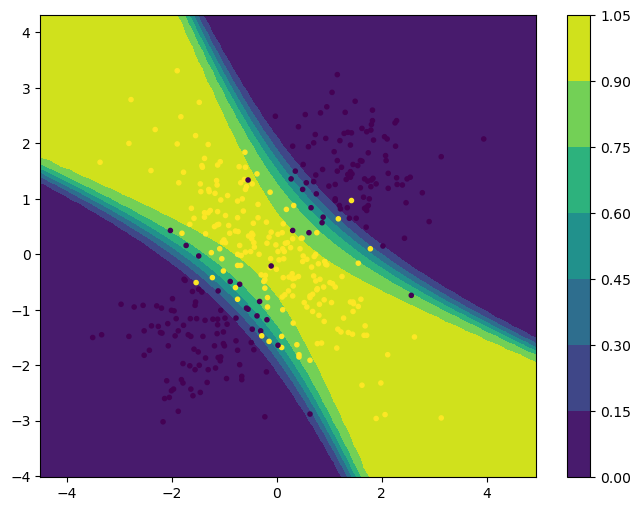

In [24]:
# Fit the polynomial model with optimal prarmeters and the option to compute the probabilities
svm_poly = SVC(kernel='poly', C=cv.best_params_["C"], degree=cv.best_params_["degree"], probability=True).fit(X_ex4, y_ex4)

# Create a grid of inputs for plotting
x1lim = [X_ex4[:,0].min(),X_ex4[:,0].max()]
x2lim = [X_ex4[:,1].min(),X_ex4[:,1].max()]
    
xx1 = np.linspace(x1lim[0]-1, x1lim[1]+1, 50)
xx2 = np.linspace(x2lim[0]-1, x2lim[1]+1, 50)
XX2, XX1 = np.meshgrid(xx2, xx1)
    
# Calculate the probabiltiy for each point in the grid
xx = np.c_[XX1.ravel(), XX2.ravel()]
xx.shape
P = svm_poly.predict_proba(xx)[:,0].reshape(XX1.shape)

plt.figure(figsize=(8,6))
plt.contourf(XX1, XX2, P)
plt.colorbar()
plt.scatter(x=X_ex4[:,0], y=X_ex4[:,1],c = 1-y_ex4, marker = '.')
plt.show()

Notice how the model is quite **confident in the predictions (probabilities close to 0 or 1)** in the corners of the input space, even where we don't have any data.  In some cases, this may be undesirable, as we may not want to make such confident assesments in areas where we have little to no data.

### 🚩 Exercise 8  (EXTRA)

- For the SVM with RBF kernel and optimal CV parameters, repeat the plot above to visualize the probabilities of class assignments.
- How do the results compare with the polynomial kernel? Does this impact your choice of kernel?

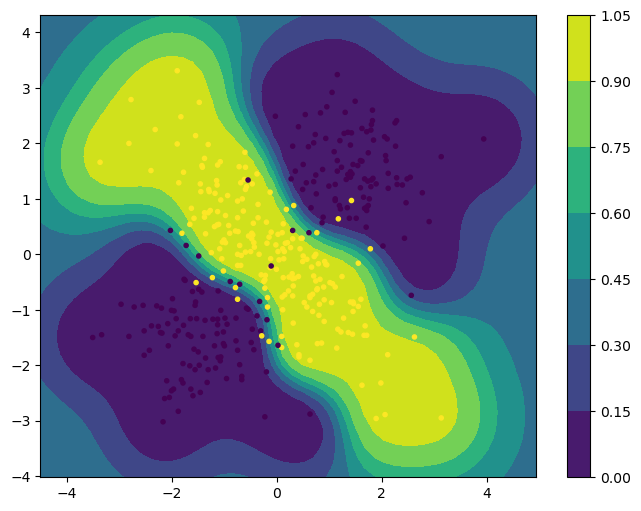

In [25]:
# Fit the rbf model with optimal prarmeters and the option to compute the probabilities
svm_rbf = SVC(kernel='rbf', C=cv2.best_params_["C"], gamma=cv2.best_params_["gamma"], probability=True).fit(X_ex4, y_ex4)

# Create a grid of inputs for plotting
x1lim = [X_ex4[:,0].min(),X_ex4[:,0].max()]
x2lim = [X_ex4[:,1].min(),X_ex4[:,1].max()]
    
xx1 = np.linspace(x1lim[0]-1, x1lim[1]+1, 50)
xx2 = np.linspace(x2lim[0]-1, x2lim[1]+1, 50)
XX2, XX1 = np.meshgrid(xx2, xx1)
    
# Calculate the probabiltiy for each point in the grid
xx = np.c_[XX1.ravel(), XX2.ravel()]
xx.shape
P = svm_rbf.predict_proba(xx)[:,0].reshape(XX1.shape)

plt.figure(figsize=(8,6))
plt.contourf(XX1, XX2, P)
plt.colorbar()
plt.scatter(x=X_ex4[:,0], y=X_ex4[:,1],c = 1-y_ex4, marker = '.')
plt.show()

Although the RBF kernel has slightly overwiggly boundaries (which we may improve by choosing a smaller $\gamma$), compared with the polynomial kernel, the class probabilities are close to 0.5 in the corners where we have no data. This may be more desirable, to avoid making any strong statements in such regions. 

We can also plot the ROC curve for both models from the Platt scaling probabilities, which are very similar for both models.

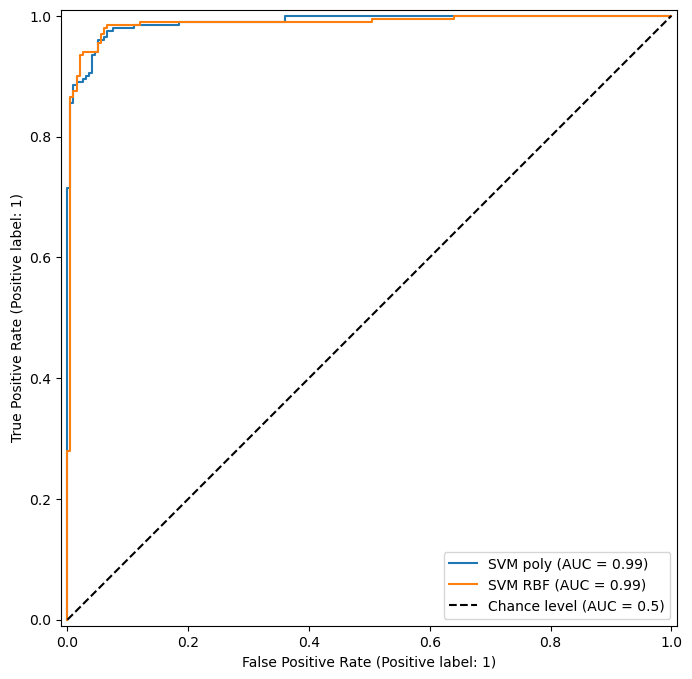

In [26]:
from sklearn.metrics import RocCurveDisplay

# Plot the ROC curve
fig, ax = plt.subplots(figsize=(8,8))
RocCurveDisplay.from_estimator(svm_poly, X_ex4, y_ex4, ax = ax, name = 'SVM poly')
RocCurveDisplay.from_estimator(svm_rbf, X_ex4, y_ex4,plot_chance_level=True,ax = ax, name = 'SVM RBF')
plt.show()

# Default Data <a id='default'></a>

Let's consider the default data that we explored last week. Recall that information is collected on **10000** individuals, recording whether they defaulted on their credit card or not as well as other characteristics. Specifically, the included columns in the data are:

* `default` - whether the individual has defaulted

* `student` - whether the individual is the student

* `balance` - balance in the individual's account

* `income` - income of the individual

In [27]:
# Load the data
df_default = pd.read_csv("Default.csv", index_col=0)

# For ease of exposition, let's' drop the student varible.
df_default = df_default.drop("student", axis=1)
df_default.head()

,default,balance,income
1,No,729.526495,44361.62507
2,No,817.180407,12106.13470
3,No,1073.549164,31767.13895
4,No,529.250605,35704.49394
5,No,785.655883,38463.49588


Next, we define our feature matrix and output vector, and split the data into a train and test set. Recall that due to the class imbalance in the data, we use the option `stratify=y` to maintain the class proportion in the test set.

In [28]:
from sklearn.model_selection import train_test_split

# Feature matrix and response vector
X, y = df_default.drop(['default'], axis=1), df_default['default']

# Convert to numpy
X = X.values

# Encode default
y = LabelEncoder().fit_transform(y)

# Stratify split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle= True, stratify=y,
                                                    test_size = 0.1, random_state=1112)

### 🚩 Exercise 9 (CORE)

a. Run the following code to fit an SVC and tune the penalty parameter `C`.

b. Plot the accuracy, recall, and f1 score as function of `C` and visualize the decision boundary. Comment on the results. 

In [29]:
# SVM with linear kernel
svm_lin = make_pipeline(
    StandardScaler(),
    SVC(kernel='linear')
)

# Grid search over C 
C = np.linspace(0.1, 10, 10)
cv_lin = GridSearchCV(
    svm_lin,
    param_grid = {'svc__C': C},
    cv = KFold(5, shuffle = True, random_state = 0),
    scoring = ["accuracy", "f1","recall"],
    refit='recall' #refit based on recall
)

# Fit and tune the model
cv_lin.fit(X_train, y_train)

# Store cv scores in a data frame 
cv_accuracy = pd.DataFrame(cv_lin.cv_results_
                           ).filter(['param_svc__C','mean_test_accuracy','mean_test_f1', 'mean_test_recall']
                                    ).rename(columns={'param_svc__C':'C','mean_test_accuracy':'CV accuracy', 'mean_test_f1':'CV f1', 'mean_test_recall':'CV recall'})

Params:  {'svc__C': 0.1}
Avg Recall:  0.0


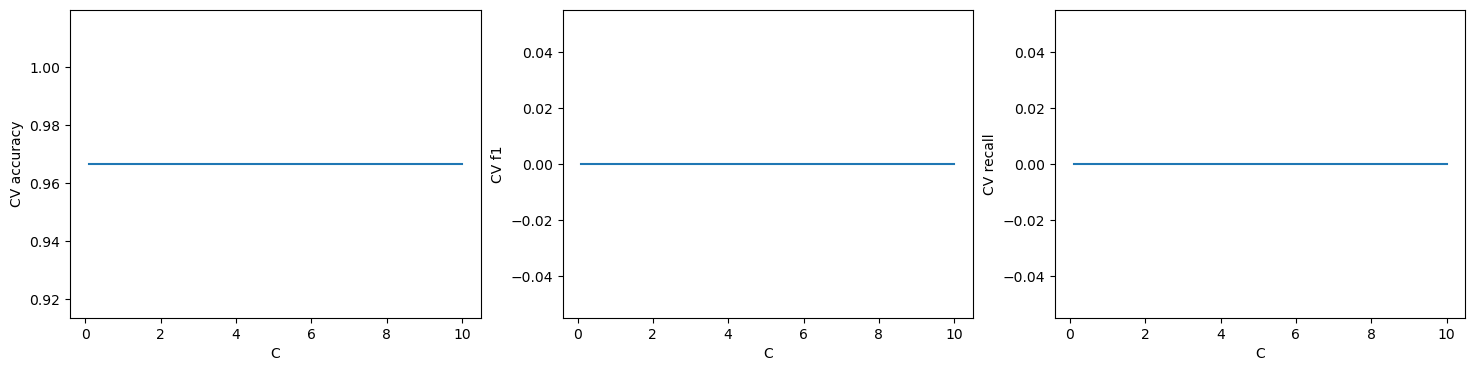

In [30]:
# Get the best model parameters and the recall of the model
print("Params: ", cv_lin.best_params_)
print("Avg Recall: ", cv_lin.best_score_)

# Plot the CV scores
fig, ax = plt.subplots(1,3,figsize=(18,4))
sns.lineplot(x='C', y='CV accuracy', data = cv_accuracy,ax=ax[0]) 
sns.lineplot(x='C', y='CV f1', data = cv_accuracy,ax=ax[1]) 
sns.lineplot(x='C', y='CV recall', data = cv_accuracy,ax=ax[2]) 
plt.show()

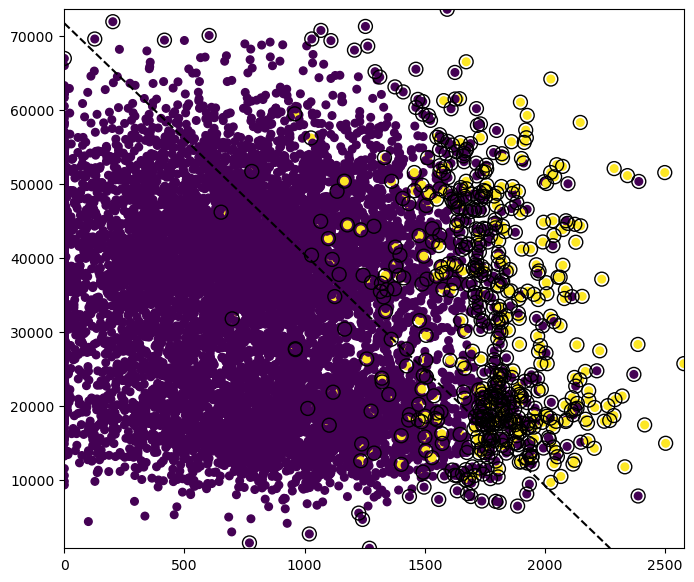

Number of support vectors: [303 300]


In [31]:
# Visualize the decision boundary
plot_margin(cv_lin.best_estimator_, X_train,y_train)
print('Number of support vectors:', cv_lin.best_estimator_[1].n_support_)

Not surprisingly, the performance is poor. Due to class imbalance, the model overfits to the majority class. We can't even see the decision boundary as the model simply predicts all individuals as not defaulting.

### 🚩 Exercise 10 (CORE)

a. To address the imbalance issue, alter the pipeline either using the `RandomOverSampler` or `RandomUnderSampler`.

b. Choose a value of `C` and plot the decision boundary and confusion matrix on the test data. How have the results changed?

In [34]:
# Install the imblearn if necessary 
#!pip install imblearn

from imblearn.pipeline import make_pipeline as Im_make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# SVM with linear kernel
svm_lin_os = Im_make_pipeline(
    StandardScaler(),
    RandomOverSampler(random_state = 0),
    SVC(kernel='linear')
)

# Grid search over C 
C = np.linspace(0.1, 10, 10)
cv_lin_os = GridSearchCV(
    svm_lin_os,
    param_grid = {'svc__C': C},
    cv = KFold(5, shuffle = True, random_state = 0),
    scoring = ["accuracy", "f1","recall"],
    refit='recall' #refit based on recall
)

# Fit and tune the model
cv_lin_os.fit(X_train, y_train)

# Store cv scores in a data frame 
cv_accuracy = pd.DataFrame(cv_lin_os.cv_results_
                           ).filter(['param_svc__C','mean_test_accuracy','mean_test_f1', 'mean_test_recall']
                                    ).rename(columns={'param_svc__C':'C','mean_test_accuracy':'CV accuracy', 'mean_test_f1':'CV f1', 'mean_test_recall':'CV recall'})

Params:  {'svc__C': 0.1}
Avg Recall:  0.8907193412891512


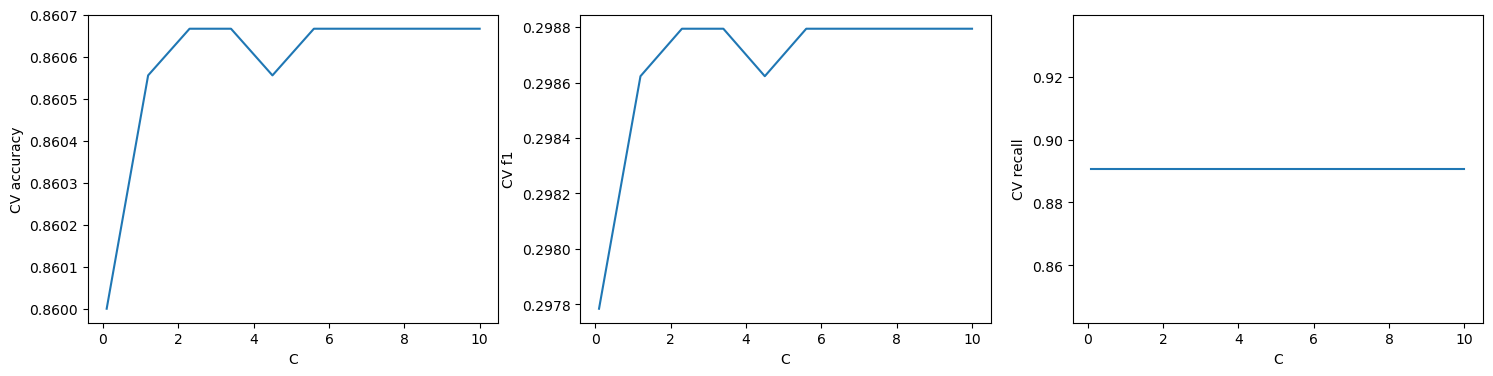

In [35]:
# Get the best model parameters and the recall of the model
print("Params: ", cv_lin_os.best_params_)
print("Avg Recall: ", cv_lin_os.best_score_)

# Plot the CV scores
fig, ax = plt.subplots(1,3,figsize=(18,4))
sns.lineplot(x='C', y='CV accuracy', data = cv_accuracy,ax=ax[0]) 
sns.lineplot(x='C', y='CV f1', data = cv_accuracy,ax=ax[1]) 
sns.lineplot(x='C', y='CV recall', data = cv_accuracy,ax=ax[2]) 
plt.show()

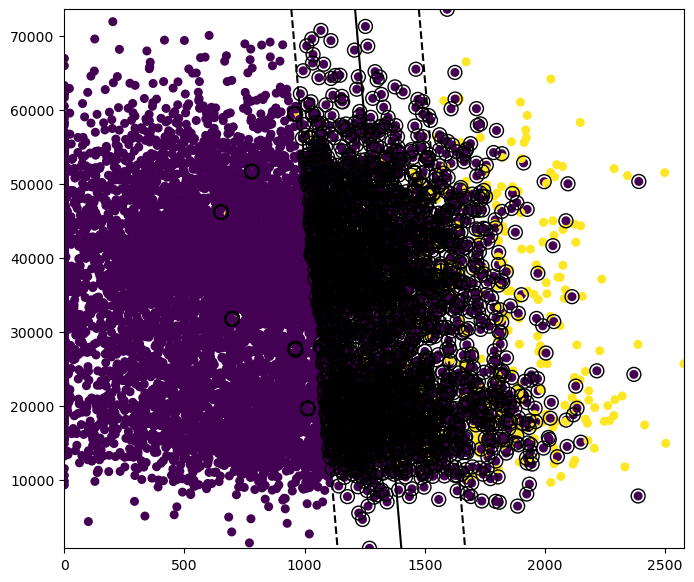

Number of support vectors: [2636 2636]


In [36]:
# Visualize the decision boundary
plot_margin(cv_lin_os.best_estimator_, X_train,y_train)
print('Number of support vectors:', cv_lin_os.best_estimator_[-1].n_support_)

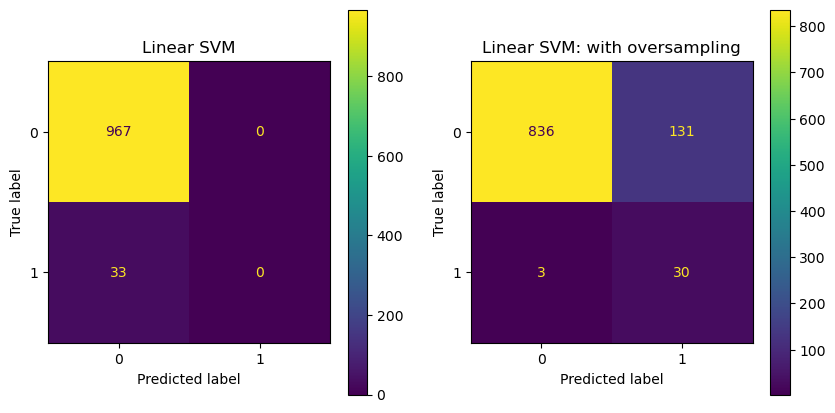

In [37]:
# Confusion matrix
fig, ax = plt.subplots(1,2,figsize=(10,5))
ConfusionMatrixDisplay.from_estimator(cv_lin.best_estimator_, X_test, y_test, ax=ax[0])
ax[0].set_title('Linear SVM')
ConfusionMatrixDisplay.from_estimator(cv_lin_os.best_estimator_, X_test, y_test, ax=ax[1])
ax[1].set_title('Linear SVM: with oversampling')
plt.show()

Now, the model no longer predicts everyone to default and is able to to identify 30/33 individuals that defaulted in the test set. This comes at the cost of 132 false positives. However, this may be preferable to the company depending on the cost of an individual that defaults, relative to not loaning to someone who defaults.

### 🚩 Exercise 11 (CORE)

Lastly, let's explore using a nonlinear decision boundary. Alter your pipeline from the previous exercise to use a polynomial kernel of degree 2 with a coefficient of 1. Visualize the decision boundary and confusion matrix on the test data. How do the results compare?

In [38]:

# SVM with polynomial kernel
svm_poly_os = Im_make_pipeline(
    StandardScaler(),
    RandomOverSampler(random_state = 0),
    SVC(kernel='poly', degree = 2, coef0=1)
)

# Grid search over C 
C = np.linspace(0.1, 10, 10)
cv_poly_os = GridSearchCV(
    svm_poly_os,
    param_grid = {'svc__C': C},
    cv = KFold(5, shuffle = True, random_state = 0),
    scoring = ["accuracy", "f1","recall"],
    refit='recall' #refit based on recall
)

# Fit and tune the model
cv_poly_os.fit(X_train, y_train)

# Store cv scores in a data frame 
cv_accuracy = pd.DataFrame(cv_poly_os.cv_results_
                           ).filter(['param_svc__C','mean_test_accuracy','mean_test_f1', 'mean_test_recall']
                                    ).rename(columns={'param_svc__C':'C','mean_test_accuracy':'CV accuracy', 'mean_test_f1':'CV f1', 'mean_test_recall':'CV recall'})

Params:  {'svc__C': 1.2000000000000002}
Avg Recall:  0.9079025332014347


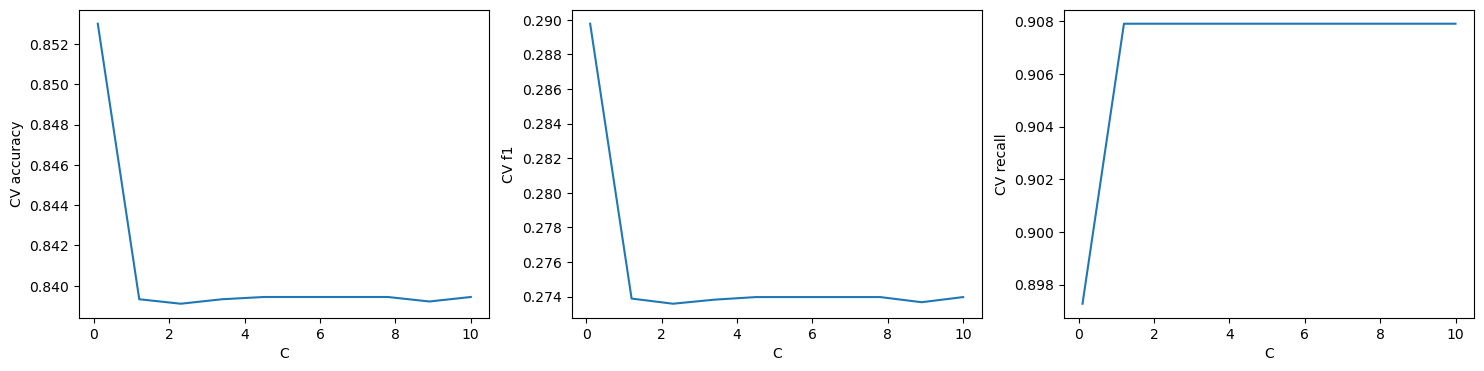

In [39]:
# Get the best model parameters and the recall of the model
print("Params: ", cv_poly_os.best_params_)
print("Avg Recall: ", cv_poly_os.best_score_)

# Plot the CV scores
fig, ax = plt.subplots(1,3,figsize=(18,4))
sns.lineplot(x='C', y='CV accuracy', data = cv_accuracy,ax=ax[0]) 
sns.lineplot(x='C', y='CV f1', data = cv_accuracy,ax=ax[1]) 
sns.lineplot(x='C', y='CV recall', data = cv_accuracy,ax=ax[2]) 
plt.show()

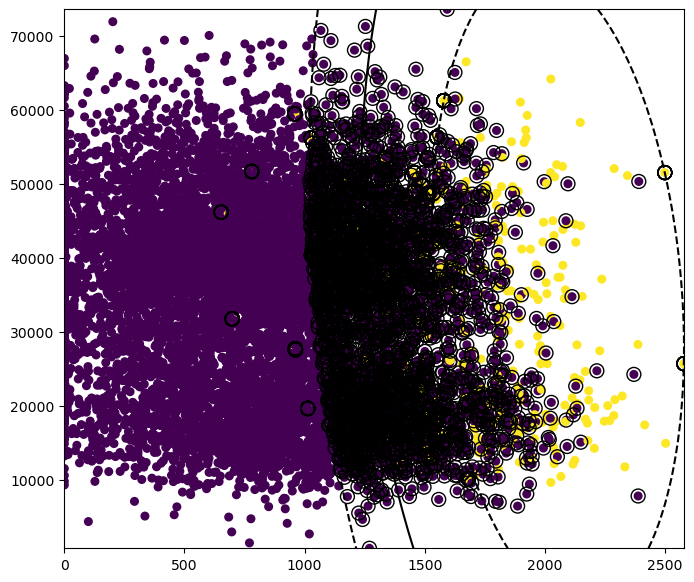

Number of support vectors: [2584 2598]


In [40]:
# Visualize the decision boundary
plot_margin(cv_poly_os.best_estimator_, X_train,y_train)
print('Number of support vectors:', cv_poly_os.best_estimator_[-1].n_support_)

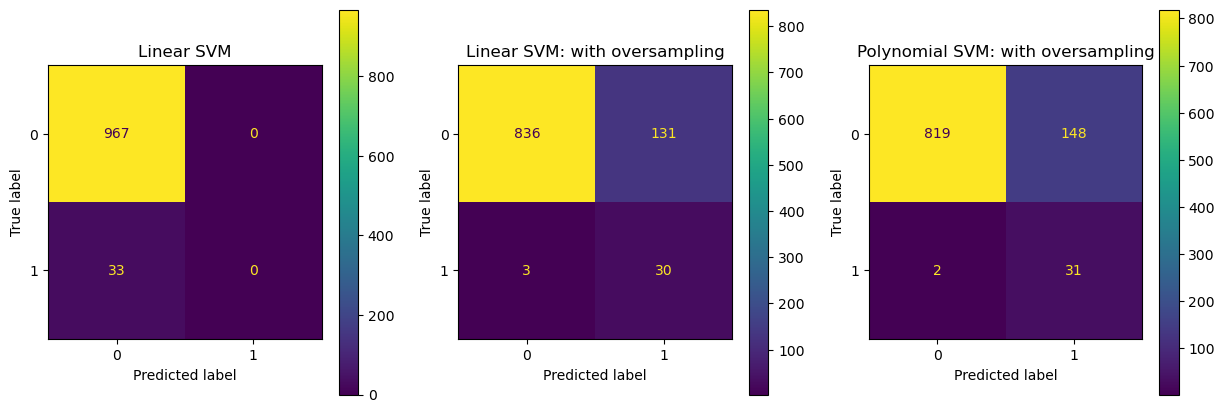

In [41]:
# Confusion matrix
fig, ax = plt.subplots(1,3,figsize=(15,5))
ConfusionMatrixDisplay.from_estimator(cv_lin.best_estimator_, X_test, y_test, ax=ax[0])
ax[0].set_title('Linear SVM')
ConfusionMatrixDisplay.from_estimator(cv_lin_os.best_estimator_, X_test, y_test, ax=ax[1])
ax[1].set_title('Linear SVM: with oversampling')
ConfusionMatrixDisplay.from_estimator(cv_poly_os.best_estimator_, X_test, y_test, ax = ax[2])
ax[2].set_title('Polynomial SVM: with oversampling')
plt.show()

The nonlinear decision boundary allows us to to identify one additional true positive, however this comes at the expensive of 17 more false negatives. Moreover, the shape of the decision boundary is very similar to the linear SVC. Thus, we may prefer the simpler linear model.  

# Competing the Worksheet

At this point you have hopefully been able to complete all the CORE exercises and attempted the EXTRA ones. Now 
is a good time to check the reproducibility of this document by restarting the notebook's
kernel and rerunning all cells in order.

Before generating the PDF, please go to Edit -> Edit Notebook Metadata and change 'Student 1' and 'Student 2' in the **name** attribute to include your name. If you are unable to edit the Notebook Metadata, please add a Markdown cell at the top of the notebook with your name(s).

Once that is done and you are happy with everything, you can then run the following cell 
to generate your PDF. Once generated, please submit this PDF on Learn page by 16:00 PM on the Friday of the week the workshop was given. 

In [44]:
!jupyter nbconvert --to pdf mlp_week07_key.ipynb 

[NbConvertApp] Converting notebook mlp_week07_key.ipynb to pdf
[NbConvertApp] Support files will be in mlp_week07_key_files/
[NbConvertApp] Making directory ./mlp_week07_key_files
[NbConvertApp] Writing 149314 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 2070764 bytes to mlp_week07_key.pdf
